# Training Mars Landmark Identifier Model with Convolutional Neural Network

### Python 2/3 Compatibility Import

In [1]:
### Python 2/3 Compatibility Import
from __future__ import absolute_import, division, print_function, unicode_literals

### Imports

In [2]:
%load_ext tensorboard

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# Helper libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os # for parallelization

In [ ]:
# Run only if needed
%reload_ext tensorboard

### Load Data

#### Pre-processing Functions

In [3]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [4]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [5]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

#### Declarations

In [6]:
# Mars Landmark Classes
CLASS_NAMES = np.array([
    "other",
    "crater",
    "dark dune",
    "slope streak",
    "bright dune",
    "impact ejecta",
    "swiss cheese",
    "spider",
])

# Image Size
IMG_WIDTH = IMG_HEIGHT = 128
BATCH_SIZE = 32

#### Loading

In [7]:
train_files = tf.data.Dataset.list_files(str("hirise-map-proj-v3/training/*/*"))
train_ds = train_files.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
test_files = tf.data.Dataset.list_files(str("hirise-map-proj-v3/testing/*/*"))
test_ds = test_files.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Image: ", image.numpy())
    print("Label: ", label.numpy())

Image shape:  (128, 128, 3)
Image:  [[[0.57554054 0.57554054 0.57554054]
  [0.57357985 0.57357985 0.57357985]
  [0.5696167  0.5696167  0.5696167 ]
  ...
  [0.9862987  0.9862987  0.9862987 ]
  [0.97178537 0.97178537 0.97178537]
  [0.971619   0.971619   0.971619  ]]

 [[0.57458645 0.57458645 0.57458645]
  [0.5695093  0.5695093  0.5695093 ]
  [0.5561275  0.5561275  0.5561275 ]
  ...
  [0.9877145  0.9877145  0.9877145 ]
  [0.9732777  0.9732777  0.9732777 ]
  [0.9688879  0.9688879  0.9688879 ]]

 [[0.55230665 0.55230665 0.55230665]
  [0.54551166 0.54551166 0.54551166]
  [0.5417319  0.5417319  0.5417319 ]
  ...
  [0.9803922  0.9803922  0.9803922 ]
  [0.9662642  0.9662642  0.9662642 ]
  [0.95863974 0.95863974 0.95863974]]

 ...

 [[0.7525211  0.7525211  0.7525211 ]
  [0.74173903 0.74173903 0.74173903]
  [0.7142636  0.7142636  0.7142636 ]
  ...
  [0.77775544 0.77775544 0.77775544]
  [0.7923756  0.7923756  0.7923756 ]
  [0.76120454 0.76120454 0.76120454]]

 [[0.7440673  0.7440673  0.7440673 ]
 

#### Batching

In [12]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=10000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds

In [13]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [15]:
X_train = prepare_for_training(train_ds)

image_batch, label_batch = next(iter(X_train))

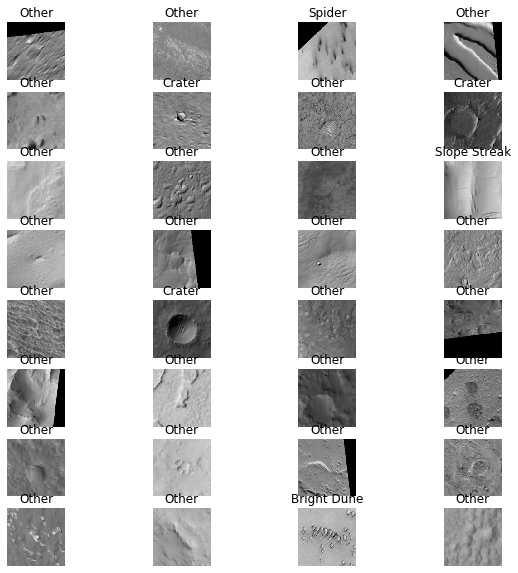

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())

### Modeling

In [17]:
# CNN Model
model = Sequential(name="MLI_CNN")
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(8, activation="softmax"))

model.summary()

Model: "MLI_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3211

### Compile & Train

In [18]:
# Compile model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Logs for Tensorboard
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
# Fitting
MLI_FIT = model.fit(train_ds,
                    epochs=10,
                    steps_per_epoch=100,
                    callbacks=[tensorboard_callback],
                    validation_split=0.1
                    )

model.save("models/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".h5")

ValueError: in converted code:

    /Users/knytes/anaconda3/envs/machinelearning/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /Users/knytes/anaconda3/envs/machinelearning/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /Users/knytes/anaconda3/envs/machinelearning/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_utils.py:573 standardize_input_data
        'with shape ' + str(data_shape))

    ValueError: Error when checking input: expected conv2d_input to have 4 dimensions, but got array with shape (128, 128, 3)


#### Tensorboard

In [ ]:
%tensorboard --logdir logs/fit

### Evaluate